In [1]:
import os
import sys
from dotenv import load_dotenv
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torchinfo import summary

load_dotenv()

sys.path.append(os.path.abspath(os.path.join("../..")))
from src.datasets.huggingfacedataset import HuggingFaceDataset  # noqa: E402
from src.models.convoluationaltransformer.convtrans_v1 import Captcha_Convolutional_Transformer_V1

In [2]:
captcha_transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((40, 150)),
        transforms.RandomInvert(p=0.5),
        transforms.ToTensor(),
    ]
)
dataset = HuggingFaceDataset(
    root_dir="/nfs/home/tpz8688/Captcha-Recognition/data/hammer_captchas", 
    transform=captcha_transformation, 
    preload=False # TODO: Set to true to get best possible performance on training
)

In [38]:
# import numpy as np

# # Convert cached_images to tensors
# cached_images_tensor = [torch.tensor(np.array(img)) for img in dataset.cached_images]

# # Save everything
# torch.save({
#     "images": cached_images_tensor,
#     "labels": dataset.cached_labels
# }, "preprocessed_hf_dataset.pt")

In [3]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_size, val_size, test_size

(1092699, 136587, 136588)

In [4]:
def captcha_collate_fn(batch):
    """
    batch is a list of tuples: [(image, label, length), ...]
    """
    images, labels, lengths = zip(*batch)
    
    # Stack images into [Batch, Channels, H, W]
    images = torch.stack(images, 0)
    
    # Pad labels into [Batch, Max_Label_Len_In_Batch]
    # padding_value=0 is the 'blank' index
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    
    # Convert lengths to a tensor
    label_lengths = torch.tensor(lengths, dtype=torch.long)
    
    return images, labels_padded, label_lengths

In [5]:
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=captcha_collate_fn, num_workers=8, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=captcha_collate_fn, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=captcha_collate_fn)

In [6]:
model = Captcha_Convolutional_Transformer_V1(num_chars=len(dataset.vocab) + 1)  # Add Blank Character to Vocabulary
summary(model, input_size=(1, 1, 40, 150))

/nfs/home/tpz8688/Captcha-Recognition/src/models/convoluationaltransformer/convtrans_v1.py:93: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(


Layer (type:depth-idx)                        Output Shape              Param #
Captcha_Convolutional_Transformer_V1          [1, 37, 63]               --
├─Sequential: 1-1                             [1, 256, 5, 37]           --
│    └─Conv2d: 2-1                            [1, 32, 40, 150]          320
│    └─BatchNorm2d: 2-2                       [1, 32, 40, 150]          64
│    └─SiLU: 2-3                              [1, 32, 40, 150]          --
│    └─MaxPool2d: 2-4                         [1, 32, 20, 75]           --
│    └─Conv2d: 2-5                            [1, 64, 20, 75]           18,496
│    └─BatchNorm2d: 2-6                       [1, 64, 20, 75]           128
│    └─SiLU: 2-7                              [1, 64, 20, 75]           --
│    └─MaxPool2d: 2-8                         [1, 64, 10, 37]           --
│    └─Conv2d: 2-9                            [1, 128, 10, 37]          73,856
│    └─BatchNorm2d: 2-10                      [1, 128, 10, 37]          256
│    └─Si

In [7]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    # 1. Unpack images, labels, AND lengths
    for images, labels, lengths in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)
        # lengths stays as a CPU tensor (CTCLoss prefers it there)

        optimizer.zero_grad()

        # Forward pass
        logits = model(images) # [Batch, Time, Vocab]

        # Prepare for CTC (Log Softmax + Permute)
        # log_probs shape: [Time, Batch, Vocab]
        log_probs = torch.nn.functional.log_softmax(logits, dim=2).permute(1, 0, 2)

        # 2. Input lengths: The number of time steps (37)
        batch_size = images.size(0)
        input_lengths = torch.full(
            (batch_size,), log_probs.size(0), dtype=torch.long
        )

        # 3. Target lengths: Use the ACTUAL lengths from the dataset/collate_fn
        target_lengths = lengths 

        # Calculate Loss
        loss = criterion(log_probs, labels, input_lengths, target_lengths)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [8]:
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        # 1. Unpack images, labels, and the actual label lengths
        for images, labels, lengths in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images) # [Batch, Time, Vocab]

            # 2. Prepare for CTC (Log Softmax + Permute)
            # log_probs shape: [Time, Batch, Vocab]
            log_probs = torch.nn.functional.log_softmax(logits, dim=2).permute(1, 0, 2)

            # 3. Input lengths: The number of time steps (usually 37)
            batch_size = images.size(0)
            input_lengths = torch.full(
                (batch_size,), log_probs.size(0), dtype=torch.long
            )

            # 4. Target lengths: Use the ACTUAL lengths provided by the loader
            target_lengths = lengths 

            # Calculate Loss
            loss = criterion(log_probs, labels, input_lengths, target_lengths)
            val_loss += loss.item()

    return val_loss / len(dataloader)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 1. Define the Criterion outside the loop
# blank=0 matches your dataset's self.idx_to_char[0] = ""
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=3,
)

num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # 2. Pass 'criterion' into both functions
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"LR: {current_lr:.6f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Ensure the directory exists before saving
        model.SAVE_DIR.mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), model.SAVE_DIR / "v2.pth")
        print(f"--> New best model saved (Val Loss: {best_val_loss:.4f})")
    
    print("-" * 30)

Training:   0%|          | 0/8537 [00:00<?, ?it/s]

Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.63it/s]


Epoch 1/50
LR: 0.000400 | Train Loss: 0.7662 | Val Loss: 0.4233
--> New best model saved (Val Loss: 0.4233)
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.63it/s]


Epoch 2/50
LR: 0.000400 | Train Loss: 0.4341 | Val Loss: 0.3686
--> New best model saved (Val Loss: 0.3686)
------------------------------


Training: 100%|██████████| 8537/8537 [05:47<00:00, 24.58it/s]


Epoch 3/50
LR: 0.000400 | Train Loss: 0.3865 | Val Loss: 0.3389
--> New best model saved (Val Loss: 0.3389)
------------------------------


Training: 100%|██████████| 8537/8537 [05:50<00:00, 24.37it/s]


Epoch 4/50
LR: 0.000400 | Train Loss: 0.3574 | Val Loss: 0.3167
--> New best model saved (Val Loss: 0.3167)
------------------------------


Training: 100%|██████████| 8537/8537 [05:45<00:00, 24.69it/s]


Epoch 5/50
LR: 0.000400 | Train Loss: 0.3364 | Val Loss: 0.3068
--> New best model saved (Val Loss: 0.3068)
------------------------------


Training: 100%|██████████| 8537/8537 [05:47<00:00, 24.55it/s]


Epoch 6/50
LR: 0.000400 | Train Loss: 0.3194 | Val Loss: 0.2960
--> New best model saved (Val Loss: 0.2960)
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.61it/s]


Epoch 7/50
LR: 0.000400 | Train Loss: 0.3051 | Val Loss: 0.2915
--> New best model saved (Val Loss: 0.2915)
------------------------------


Training: 100%|██████████| 8537/8537 [05:47<00:00, 24.59it/s]


Epoch 8/50
LR: 0.000400 | Train Loss: 0.2920 | Val Loss: 0.2774
--> New best model saved (Val Loss: 0.2774)
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.63it/s]


Epoch 9/50
LR: 0.000400 | Train Loss: 0.2800 | Val Loss: 0.2662
--> New best model saved (Val Loss: 0.2662)
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.65it/s]


Epoch 10/50
LR: 0.000400 | Train Loss: 0.2691 | Val Loss: 0.2632
--> New best model saved (Val Loss: 0.2632)
------------------------------


Training: 100%|██████████| 8537/8537 [05:45<00:00, 24.68it/s]


Epoch 11/50
LR: 0.000400 | Train Loss: 0.2592 | Val Loss: 0.2603
--> New best model saved (Val Loss: 0.2603)
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.66it/s]


Epoch 12/50
LR: 0.000400 | Train Loss: 0.2522 | Val Loss: 0.2562
--> New best model saved (Val Loss: 0.2562)
------------------------------


Training: 100%|██████████| 8537/8537 [05:45<00:00, 24.70it/s]


Epoch 13/50
LR: 0.000400 | Train Loss: 0.2468 | Val Loss: 0.2501
--> New best model saved (Val Loss: 0.2501)
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.65it/s]


Epoch 14/50
LR: 0.000400 | Train Loss: 0.2421 | Val Loss: 0.2478
--> New best model saved (Val Loss: 0.2478)
------------------------------


Training: 100%|██████████| 8537/8537 [05:45<00:00, 24.71it/s]


Epoch 15/50
LR: 0.000400 | Train Loss: 0.2387 | Val Loss: 0.2476
--> New best model saved (Val Loss: 0.2476)
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.63it/s]


Epoch 16/50
LR: 0.000400 | Train Loss: 0.2360 | Val Loss: 0.2485
------------------------------


Training: 100%|██████████| 8537/8537 [05:45<00:00, 24.70it/s]


Epoch 17/50
LR: 0.000400 | Train Loss: 0.2331 | Val Loss: 0.2485
------------------------------


Training: 100%|██████████| 8537/8537 [05:47<00:00, 24.58it/s]


Epoch 18/50
LR: 0.000400 | Train Loss: 0.2309 | Val Loss: 0.2479
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.64it/s]


Epoch 19/50
LR: 0.000200 | Train Loss: 0.2288 | Val Loss: 0.2478
------------------------------


Training: 100%|██████████| 8537/8537 [05:47<00:00, 24.60it/s]


Epoch 20/50
LR: 0.000200 | Train Loss: 0.2113 | Val Loss: 0.2389
--> New best model saved (Val Loss: 0.2389)
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.66it/s]


Epoch 21/50
LR: 0.000200 | Train Loss: 0.2077 | Val Loss: 0.2407
------------------------------


Training: 100%|██████████| 8537/8537 [05:45<00:00, 24.73it/s]


Epoch 22/50
LR: 0.000200 | Train Loss: 0.2060 | Val Loss: 0.2436
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.66it/s]


Epoch 23/50
LR: 0.000200 | Train Loss: 0.2044 | Val Loss: 0.2460
------------------------------


Training: 100%|██████████| 8537/8537 [05:45<00:00, 24.72it/s]


Epoch 24/50
LR: 0.000100 | Train Loss: 0.2033 | Val Loss: 0.2457
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.67it/s]


Epoch 25/50
LR: 0.000100 | Train Loss: 0.1958 | Val Loss: 0.2450
------------------------------


Training: 100%|██████████| 8537/8537 [05:45<00:00, 24.69it/s]


Epoch 26/50
LR: 0.000100 | Train Loss: 0.1940 | Val Loss: 0.2476
------------------------------


Training: 100%|██████████| 8537/8537 [05:45<00:00, 24.73it/s]


Epoch 27/50
LR: 0.000100 | Train Loss: 0.1934 | Val Loss: 0.2510
------------------------------


Training: 100%|██████████| 8537/8537 [05:46<00:00, 24.65it/s]


Epoch 28/50
LR: 0.000050 | Train Loss: 0.1926 | Val Loss: 0.2520
------------------------------


Training:  61%|██████▏   | 5244/8537 [03:34<02:14, 24.50it/s]
Traceback (most recent call last):
  File "/nfs/home/tpz8688/.local/share/uv/python/cpython-3.13.9-linux-x86_64-gnu/lib/python3.13/threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/nfs/home/tpz8688/.local/share/uv/python/cpython-3.13.9-linux-x86_64-gnu/lib/python3.13/threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/nfs/home/tpz8688/Captcha-Recognition/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/pin_memory.py", line 52, in _pin_memory_loop
    do_one_step()
    ~~~~~~~~~~~^^
  File "/nfs/home/tpz8688/Captcha-Recognition/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/nfs/home/tpz8688/.local/share/uv/python/cpython-3.13.9-linux-x86_64-gnu/lib/python3.13/multiprocessing/queues.py", l

KeyboardInterrupt: 

In [10]:
model = Captcha_Convolutional_Transformer_V1(num_chars=len(dataset.vocab) + 1)
state_dict = torch.load(Captcha_Convolutional_Transformer_V1.SAVE_DIR / "v2.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval() 

print(f"Model successfully loaded from {Captcha_Convolutional_Transformer_V1.SAVE_DIR / "v2.pth"}")


Model successfully loaded from /nfs/home/tpz8688/Captcha-Recognition/weights/conv_transformer/v2.pth


/nfs/home/tpz8688/Captcha-Recognition/src/models/convoluationaltransformer/convtrans_v1.py:93: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(


In [11]:
def decode_predictions(logits, dataset):
    # logits shape: (Time_Steps, Num_Chars)
    # Get the index of the highest probability for each time step
    tokens = torch.argmax(logits, dim=-1)  # Shape: (Time_Steps)

    char_list = []
    for i in range(len(tokens)):
        token = tokens[i].item()

        # CTC Rules:
        # 1. Skip the blank token (index 0)
        # 2. Skip repeated tokens (if the model predicts 'aaaa', it's just 'a')
        if token != 0:
            if i > 0 and tokens[i] == tokens[i - 1]:
                continue
            char_list.append(dataset.idx_to_char[token])

    return "".join(char_list)

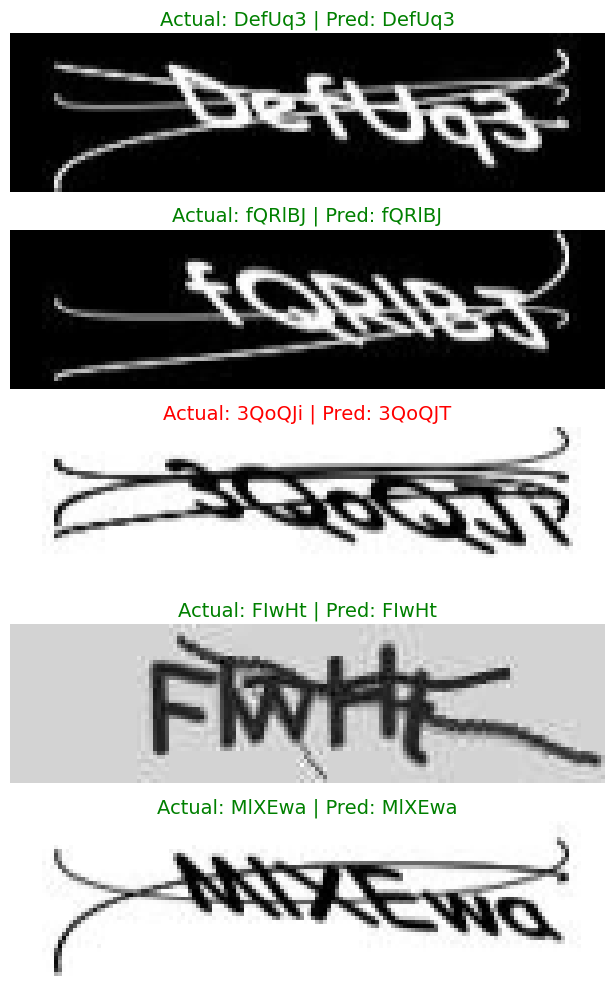

In [13]:
import matplotlib.pyplot as plt
import random


def visualize_predictions(model, dataloader, dataset, device, num_samples=5):
    model.eval()

    # 1. Get just ONE batch without loading the whole dataset
    # We use a loop that breaks immediately to grab the 'first' available batch
    # If your test_loader has shuffle=True, this will be a random batch.
    images, labels, _ = next(iter(dataloader))

    images = images.to(device)
    with torch.no_grad():
        logits = model(images)

    plt.figure(figsize=(15, 10))

    batch_size = images.size(0)
    # Pick random indices within this single batch
    indices = random.sample(range(batch_size), min(num_samples, batch_size))

    for i, idx in enumerate(indices):
        img = images[idx].cpu().squeeze().numpy()
        pred_str = decode_predictions(logits[idx], dataset)
        actual_indices = [val.item() for val in labels[idx] if val.item() != 0]
        actual_str = "".join([dataset.idx_to_char[val] for val in actual_indices])

        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img, cmap="gray")
        color = "green" if pred_str == actual_str else "red"
        plt.title(f"Actual: {actual_str} | Pred: {pred_str}", color=color, fontsize=14)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Usage:
visualize_predictions(model, test_loader, dataset, device)

In [14]:
import Levenshtein

def run_evaluation(model, dataloader, dataset, device):
    model.eval()
    
    total_samples = 0
    perfect_matches = 0
    
    total_edit_distance = 0
    total_actual_chars = 0

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            logits = model(images) # [Batch, Time, Vocab]
            
            for i in range(images.size(0)):
                # 1. Decode prediction and actual label
                pred_str = decode_predictions(logits[i], dataset)
                
                actual_indices = [val.item() for val in labels[i] if val.item() != 0]
                actual_str = "".join([dataset.idx_to_char[val] for val in actual_indices])
                
                # 2. Update Word Accuracy Stats
                if pred_str == actual_str:
                    perfect_matches += 1
                total_samples += 1
                
                # 3. Update Character Accuracy Stats (Levenshtein)
                distance = Levenshtein.distance(pred_str, actual_str)
                total_edit_distance += distance
                total_actual_chars += len(actual_str)

    # Final Calculations
    word_accuracy = (perfect_matches / total_samples) * 100
    
    # Character Error Rate (CER) is distance/total_chars
    # Character Accuracy is 100 - CER
    cer = (total_edit_distance / total_actual_chars) * 100
    char_accuracy = 100 - cer

    print(f"\n" + "="*30)
    print(f"WORD ACCURACY: {word_accuracy:.2f}%")
    print(f"CHAR ACCURACY: {char_accuracy:.2f}%")
    print(f"TOTAL SAMPLES: {total_samples}")
    print("="*30)

    return word_accuracy, char_accuracy

In [15]:
run_evaluation(model, test_loader, test_dataset.dataset, device)

Evaluating: 100%|██████████| 1068/1068 [09:49<00:00,  1.81it/s]


WORD ACCURACY: 89.57%
CHAR ACCURACY: 94.03%
TOTAL SAMPLES: 136588


(89.57375464901747, 94.03396727088494)

In [ ]:
test_indices = test_dataset.indices
test_paths = [str(dataset.image_paths[i]) for i in test_indices]

with open("test_file_list_convtrans.txt", "w") as f:
    for path in test_paths:
        f.write(path + "\n")

print(f"Saved {len(test_paths)} pointers to test_file_list.txt")

Saved 136588 pointers to test_file_list.txt
